### Programa para el diseño de vigas según el código ACI

In [1]:
from math import sqrt

# Datos a ingresar por parte del usuario *************
fc = 28.0       # f'c del concreto (En MPa, <= 30 MPa)
fy = 420.0      # fy del acero (En MPa) ¡¡¡DEBE SER GRADO 60!!!
h = 0.25         # Altura total de la sección (En m)
b = 0.1         # Ancho de la sección (En m)
r = 0.035        # Recubrimiento al centroide del refuerzo (En m)
d = h - r       # Peralte efectivo
phi = 0.9       # En este programa no se modificará este factor
Mu = 11.42         # Momento de diseño (en kN-m)

# Cuantía de diseño **********************************
Rn = (Mu/1000)/(phi*b*d**2)
B = 2*Rn/(0.85*fc)

if (B >= 1):
    print('Revisar el valor de Mu')
else:
    rho = (0.85*fc/fy)*(1 - sqrt(1 - B))
    A = rho*b*d
# ****************************************************

# Deformación unitaria del acero en la falla *********
a = rho*fy*d/(0.85*fc)       # Profundidad del bloque de Whitney
c = a/0.85                   # Distancia al eje neutro desde la fibra superior
es = (d -c)*0.003/c
# ****************************************************

# Cuantía mínima *************************************
Am1 = sqrt(fc)*b*d/(4*fy)
Am2 = 1.4*b*d/fy

if (Am1 >= Am2):
    A_min = Am1
else:
    A_min = Am2
# ****************************************************

# 0.75 de la cuantía balanceada (cuantía máx) ********
rho_bal = (0.85*0.85*fc/fy)*(600/(600 + fy))
A_max = 0.75*rho_bal*b*d
A_bal = rho_bal*b*d
# ****************************************************

# Resultados de los cálculos *************************
print('El refuerzo mínimo es ', A_min*1000**2, ' mm^2')
print('El refuerzo de diseño es ', A*1000**2, ' mm^2')
print('La deformación del acero es ', es)
# Comprobar el mecanismo que controla la falla
if (es < 0.005):
    print('   ¡¡Esta sección no es controlada por tensión!!')
else:
    print('   Sección controlada por tensión. Phi=0.90')
# ********************************************
print('El refuerzo balanceado es ', A_bal*1000**2, ' mm^2')
print('El refuerzo máximo es ', A_max*1000**2, ' mm^2')

El refuerzo mínimo es  71.66666666666666  mm^2
El refuerzo de diseño es  149.71856549327805  mm^2
La deformación del acero es  0.017750599565018444
   Sección controlada por tensión. Phi=0.90
El refuerzo balanceado es  609.1666666666666  mm^2
El refuerzo máximo es  456.87499999999994  mm^2


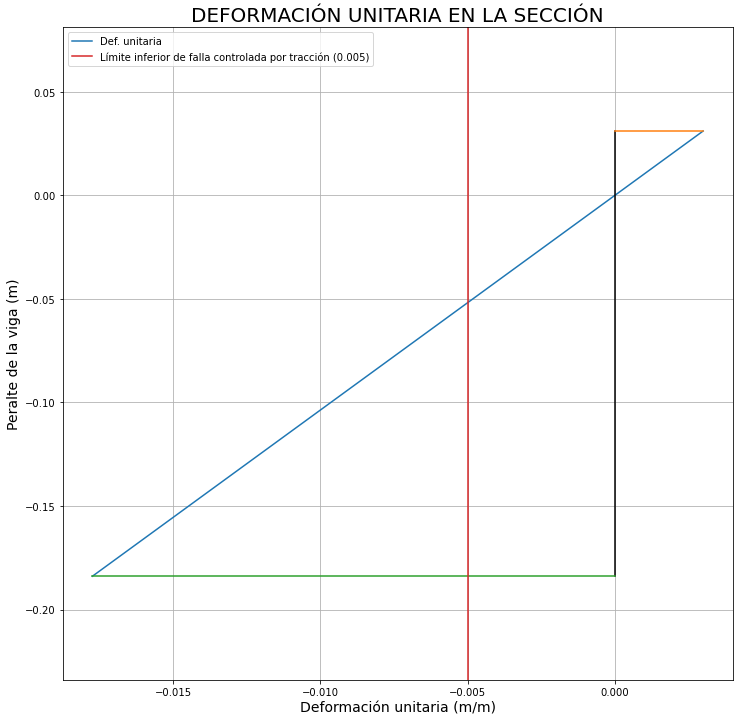

In [2]:
# Gráfica de la deformación
import matplotlib.pyplot as plt

n = 19                             # Número de puntos
m = d/(0.003 + es)
x = [i*(0.003 + es)/n - es for i in range(n+1)]
y = [m*x[i] for i in range(n+1)]

plt.figure(figsize=(12, 12))
plt.plot(x, y, label='Def. unitaria')
plt.plot([0, 0], [c-d, c], 'k')
#plt.plot([-es, 0.003], [0, 0], 'k')
plt.plot([0, 0.003], [c, c])
plt.plot([-es, 0], [c-d, c-d])
plt.plot([-0.005, -0.005], [c-d-0.05, c+0.05], label='Límite inferior de falla controlada por tracción (0.005)')
plt.legend()
plt.xlim(-es-0.001, 0.004)
plt.ylim(c-d-0.05, c+0.05)
plt.grid()
plt.ylabel('Peralte de la viga (m)', size=14)
plt.xlabel('Deformación unitaria (m/m)', size=14)
plt.title('DEFORMACIÓN UNITARIA EN LA SECCIÓN', size=20)
plt.show;

### Comprobación de requisitos DMO/DES

In [3]:
# Función que calcula momentos últimos a flexión
def mom_ult(cuantia):
    m = phi*b*(d**2)*fy*cuantia*(1 - cuantia*fy/(1.7*fc))
    return m
# **********************************************

ref_sup = [0.001, 0.0005, 0.003]     # Cuantías negativas en los extremos y en el centro
ref_inf = [0.0005, 0, 0.001]     # Cuantías positivas en los extremos y en el centro

Mu_sup = [mom_ult(i) for i in ref_sup]     # En MN-m
Mu_inf = [mom_ult(i) for i in ref_inf]     # En MN-m

a = 1/2     # Para DMO es 1/3; para DES es 1/2
b = 1/4     # Para DMO es 1/3; para DES es 1/2

# En el nudo ************************************ 
if Mu_inf[0] < a*Mu_sup[0]:
    print('No cumple el criterio EN nudo izquierdo')
else:
    print('Sí cumple el criterio EN el nudo izquierdo')
    
if Mu_inf[2] < a*Mu_sup[2]:
    print('No cumple el criterio EN el nudo derecho')
else:
    print('Sí cumple el criterio EN el nudo derecho')
# ***********************************************

# Relación de capacidad de cualquier sección respecto al nudo
if Mu_inf[1] < b*Mu_inf[0] or b*Mu_sup[0]:
    print('No cumple el criterio RESPECTO al nudo izquierdo')
else:
    print('Sí cumple el criterio RESPECTO al nudo izquierdo')

if Mu_sup[1] < b*Mu_inf[2] or b*Mu_sup[2]:
    print('No cumple el criterio RESPECTO al nudo derecho')
else:
    print('Sí cumple el criterio RESPECTO al nudo derecho')
# ***********************************************************

Sí cumple el criterio EN el nudo izquierdo
No cumple el criterio EN el nudo derecho
No cumple el criterio RESPECTO al nudo izquierdo
No cumple el criterio RESPECTO al nudo derecho


### A partir de este punto empieza el diseño a cortante

In [4]:
Mn1 = 2             # En kN-m. Es momento nominal, no momento último
Mn2 = 2             # En kN-m. Es momento nominal, no momento último
l = 5               # Luz libre de la viga
Vg = 3              # Cortante más grande por carga gravitacional en un extremo
Av = 142         # Área a cortante (2 veces el área de la varilla de estribo)

Ve = (Mn1 + Mn2)/l
Vu = Ve + Vg
Vc = b*d*sqrt(fc)/6
Vs = (Vu - 0.75*Vc)/0.75
# Límite máximo del cortante en el acero *******
Vs_max = (3/2)*sqrt(fc)*b*d
if Vs >= Vs_max:
    print('El cortante en el acero EXCEDE el máximo permitido')
# **********************************************
s = (Av*fy*d)/Vs
# Límite en la separación de los estribos ******
if s >= d/2:
    print('La separación excede el máximo permitido')
# **********************************************
print('La separación de estribos calculada es ', s, ' mm^2')

El cortante en el acero EXCEDE el máximo permitido
La separación excede el máximo permitido
La separación de estribos calculada es  2554.6775313653084  mm^2
